<a href="https://colab.research.google.com/github/Aryayemul/AI-DL-Project-Sem5/blob/main/VibeMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Why AI at Nexora**

 Nexora operates at the intersection of modern retail and digital experience design. Applying AI for a lightweight "Vibe Matcher" improves discovery, reduces friction in shopping, and personalizes recommendations in natural language. A fast semantic search (embeddings + vector similarity) helps customers express abstract preferences ("energetic urban chic") and receive curated product matches, increasing engagement and conversion while maintaining interpretability for product teams.

# Data Preparation

In [37]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import time
import numpy as np
import matplotlib.pyplot as plt

# Data **Preparation**

In [23]:
data = [
     {"name": "Boho Dress",
     "desc": "Flowy maxi dress in earthy tones, perfect for festivals and beach vibes.",
     "vibes": ["boho", "free-spirited"]},
    {"name": "Urban Bomber Jacket",
     "desc": "Sleek black bomber jacket with minimalist lines for street-smart looks.",
     "vibes": ["urban", "chic"]},
    {"name": "Cozy Knit Sweater",
     "desc": "Soft oversized sweater made for rainy days and coffee shop lounging.",
     "vibes": ["cozy", "casual"]},
    {"name": "Vintage Denim Jeans",
     "desc": "High-waisted faded jeans with a timeless retro edge.",
     "vibes": ["vintage", "classic"]},
    {"name": "Sporty Sneakers",
     "desc": "Lightweight, breathable sneakers built for an energetic urban lifestyle.",
     "vibes": ["sporty", "energetic"]},
    {"name": "Glam Sequin Top",
     "desc": "Shimmering sequin top for dazzling nights out and party moods.",
     "vibes": ["glam", "party"]},
    {"name": "Minimalist White Tee",
     "desc": "Clean-cut white t-shirt for effortless, modern everyday style.",
     "vibes": ["minimal", "modern"]},
    {"name": "Rugged Leather Boots",
     "desc": "Tough brown boots that add edge and attitude to any outfit.",
     "vibes": ["rugged", "edgy"]},
]

In [24]:
data = pd.DataFrame(data)

In [25]:
data

,name,desc,vibes
0,Boho Dress,"Flowy maxi dress in earthy tones, perfect for ...","[boho, free-spirited]"
1,Urban Bomber Jacket,Sleek black bomber jacket with minimalist line...,"[urban, chic]"
2,Cozy Knit Sweater,Soft oversized sweater made for rainy days and...,"[cozy, casual]"
3,Vintage Denim Jeans,High-waisted faded jeans with a timeless retro...,"[vintage, classic]"
4,Sporty Sneakers,"Lightweight, breathable sneakers built for an ...","[sporty, energetic]"
5,Glam Sequin Top,Shimmering sequin top for dazzling nights out ...,"[glam, party]"
6,Minimalist White Tee,"Clean-cut white t-shirt for effortless, modern...","[minimal, modern]"
7,Rugged Leather Boots,Tough brown boots that add edge and attitude t...,"[rugged, edgy]"


# **Embeddings**

In [26]:
from sentence_transformers import SentenceTransformer

In [27]:
# Load a free, local embedding model
model = SentenceTransformer('all-mpnet-base-v2')  # ~384-dimensional embeddings


In [28]:
# Compute and store embeddings
desc_embeddings = model.encode(data["desc"].tolist(),convert_to_numpy=True)
data["embedding"] = list(desc_embeddings)

# **Vector Similarity Search-Cosine Similarity**

In [29]:

def vibe_matcher(query,top_k=3):
  start = time.time()
  query_emb = model.encode([query],convert_to_numpy=True)
  sim = cosine_similarity(query_emb,desc_embeddings)[0]
  data['similarty'] = sim
  ranked = data.sort_values("similarty",ascending=False).head(top_k)
  latency = time.time() -start


  #fallback
  if ranked["similarty"].iloc[0] < 0.3:
    print("No strong vibe match found.")
  return ranked[["name", "desc", "vibes", "similarty"]], latency

# **Test & Evaluation**

In [30]:
queries = [
    "energetic urban chic",
    "relaxed cozy weekend",
    "professional minimalist outfit"
]

results = []
latencies = []
good_matches = 0
scores = []



In [32]:
for q in queries:
    print(f"\nQuery: {q}")
    top3, latency = vibe_matcher(q)
    latencies.append(latency)

    if top3 is not None:
        print(top3, "\n")
        top_score = top3["similarty"].iloc[0]
        scores.append(top_score)
        if top_score > 0.7:
            good_matches += 1
        results.append({"query": q, "top": top3.iloc[0]["name"], "score": top_score})
    else:
        print("⚠️ No strong match found\n")
        results.append({"query": q, "top": None, "score": 0})
        scores.append(0)


Query: energetic urban chic
                  name                                               desc  \
4      Sporty Sneakers  Lightweight, breathable sneakers built for an ...   
0           Boho Dress  Flowy maxi dress in earthy tones, perfect for ...   
1  Urban Bomber Jacket  Sleek black bomber jacket with minimalist line...   

                   vibes  similarty  
4    [sporty, energetic]   0.436246  
0  [boho, free-spirited]   0.424893  
1          [urban, chic]   0.409458   


Query: relaxed cozy weekend
                   name                                               desc  \
2     Cozy Knit Sweater  Soft oversized sweater made for rainy days and...   
6  Minimalist White Tee  Clean-cut white t-shirt for effortless, modern...   
5       Glam Sequin Top  Shimmering sequin top for dazzling nights out ...   

               vibes  similarty  
2     [cozy, casual]   0.470095  
6  [minimal, modern]   0.306226  
5      [glam, party]   0.289521   


Query: professional minimal

In [35]:
avg_latency = np.mean(latencies)
avg_score = np.mean(scores)
good_match_ratio = good_matches / len(queries)

In [36]:
print("\n=== Evaluation Summary ===")
print(f"Average similarity score: {avg_score:.3f}")
print(f"Average latency: {avg_latency:.3f} s")
print(f"Good matches (>0.7): {good_matches}/{len(queries)} ({good_match_ratio*100:.1f}%)")


=== Evaluation Summary ===
Average similarity score: 0.491
Average latency: 0.070 s
Good matches (>0.7): 0/3 (0.0%)


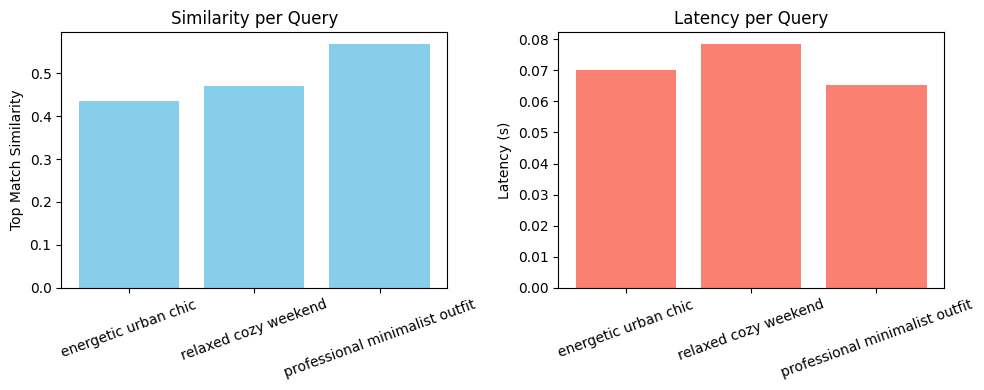

In [40]:
plt.figure(figsize=(10, 4))

# Plot 1: Similarity scores
plt.subplot(1, 2, 1)
plt.bar(range(len(queries)), scores, color="skyblue")
plt.xticks(range(len(queries)), queries, rotation=20)
plt.ylabel("Top Match Similarity")
plt.title("Similarity per Query")

# Plot 2: Latency
plt.subplot(1, 2, 2)
# Ensure latencies has the same length as queries before plotting
# This handles cases where latencies might have accumulated extra values
latencies_to_plot = latencies[:len(queries)] # Truncate latencies if it's longer than queries

plt.bar(range(len(queries)), latencies_to_plot, color="salmon")
plt.xticks(range(len(queries)), queries, rotation=20)
plt.ylabel("Latency (s)")
plt.title("Latency per Query")

plt.tight_layout()
plt.show()

# **Reflection Improvements & Edge Cases**

**Refelection**

   * Improvements:

    1.Improving accuracy using large data set and higher quailty embedding model

    2.Interating vector DB(Pincone or Chroma dB) for persistance and faster scale.
  
  * Edge cases handled:
    
    1.no match fallback.
